### Step 1: Import Libraries and Load Data

In [113]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.regime_switching.markov_switching import MarkovSwitching
from sklearn.metrics import mean_absolute_error, mean_squared_error


brent_prices = pd.read_csv("../data/cleaned_data.csv")  
exchange_rates = pd.read_csv("../data/data_collected/Exchange_rates.csv", skiprows=4)
inflation = pd.read_csv("../data/data_collected/inflation.csv", skiprows=4)
gdp_growth = pd.read_csv("../data/data_collected/GDP_growth.csv", skiprows=4)


In [115]:
print(brent_prices.head())

         Date  Price
0  1987-05-20  18.63
1  1987-05-21  18.45
2  1987-05-22  18.55
3  1987-05-25  18.60
4  1987-05-26  18.63


### Step 2: Inspect Datasets and Convert Dates

In [116]:
print(gdp_growth.head())
print(exchange_rates.head())
print(inflation.head())


                  Country Name Country Code         Indicator Name  \
0                        Aruba          ABW  GDP growth (annual %)   
1  Africa Eastern and Southern          AFE  GDP growth (annual %)   
2                  Afghanistan          AFG  GDP growth (annual %)   
3   Africa Western and Central          AFW  GDP growth (annual %)   
4                       Angola          AGO  GDP growth (annual %)   

      Indicator Code  1960      1961      1962      1963      1964      1965  \
0  NY.GDP.MKTP.KD.ZG   NaN       NaN       NaN       NaN       NaN       NaN   
1  NY.GDP.MKTP.KD.ZG   NaN  0.460106  7.868013  5.616400  4.668135  5.138990   
2  NY.GDP.MKTP.KD.ZG   NaN       NaN       NaN       NaN       NaN       NaN   
3  NY.GDP.MKTP.KD.ZG   NaN  1.873455  3.707643  7.145784  5.406403  4.102491   
4  NY.GDP.MKTP.KD.ZG   NaN       NaN       NaN       NaN       NaN       NaN   

   ...      2015      2016      2017      2018      2019       2020  \
0  ... -0.623626  1.719625 

### Merge Economic Indicators

In [117]:
exchange_rates_long = exchange_rates.melt(id_vars=["Country Name", "Country Code"], 
                                          var_name="Year", 
                                          value_name="Exchange Rate")
exchange_rates_long["Year"] = pd.to_numeric(exchange_rates_long["Year"], errors='coerce')

inflation_long = inflation.melt(id_vars=["Country Name", "Country Code"], 
                                var_name="Year", 
                                value_name="Inflation")
inflation_long["Year"] = pd.to_numeric(inflation_long["Year"], errors='coerce')

gdp_growth_long = gdp_growth.melt(id_vars=["Country Name", "Country Code"], 
                                  var_name="Year", 
                                  value_name="GDP Growth")
gdp_growth_long["Year"] = pd.to_numeric(gdp_growth_long["Year"], errors='coerce')


In [118]:
merged_economic_data = pd.merge(exchange_rates_long, inflation_long, on=["Country Name", "Country Code", "Year"], how="inner")
merged_economic_data = pd.merge(merged_economic_data, gdp_growth_long, on=["Country Name", "Country Code", "Year"], how="inner")


print("Merged Economic Data:\n", merged_economic_data.head())

Merged Economic Data:
   Country Name Country Code  Year  \
0        Aruba          ABW   NaN   
1        Aruba          ABW   NaN   
2        Aruba          ABW   NaN   
3        Aruba          ABW   NaN   
4        Aruba          ABW   NaN   

                                       Exchange Rate  \
0  Official exchange rate (LCU per US$, period av...   
1  Official exchange rate (LCU per US$, period av...   
2  Official exchange rate (LCU per US$, period av...   
3  Official exchange rate (LCU per US$, period av...   
4  Official exchange rate (LCU per US$, period av...   

                               Inflation             GDP Growth  
0  Inflation, consumer prices (annual %)  GDP growth (annual %)  
1  Inflation, consumer prices (annual %)      NY.GDP.MKTP.KD.ZG  
2  Inflation, consumer prices (annual %)                    NaN  
3                         FP.CPI.TOTL.ZG  GDP growth (annual %)  
4                         FP.CPI.TOTL.ZG      NY.GDP.MKTP.KD.ZG  


In [119]:
merged_economic_data.to_csv('../data/merged_data.csv')

In [120]:
merged_economic_data_2 = pd.read_csv('../data/merged_economic_indicators.csv')

In [121]:
years_needed = merged_economic_data['Year'].unique()

filtered_economic_data = merged_economic_data[merged_economic_data['Year'].isin(years_needed)]
print("Filtered Economic Data:\n", filtered_economic_data.head())

Filtered Economic Data:
   Country Name Country Code  Year  \
0        Aruba          ABW   NaN   
1        Aruba          ABW   NaN   
2        Aruba          ABW   NaN   
3        Aruba          ABW   NaN   
4        Aruba          ABW   NaN   

                                       Exchange Rate  \
0  Official exchange rate (LCU per US$, period av...   
1  Official exchange rate (LCU per US$, period av...   
2  Official exchange rate (LCU per US$, period av...   
3  Official exchange rate (LCU per US$, period av...   
4  Official exchange rate (LCU per US$, period av...   

                               Inflation             GDP Growth  
0  Inflation, consumer prices (annual %)  GDP growth (annual %)  
1  Inflation, consumer prices (annual %)      NY.GDP.MKTP.KD.ZG  
2  Inflation, consumer prices (annual %)                    NaN  
3                         FP.CPI.TOTL.ZG  GDP growth (annual %)  
4                         FP.CPI.TOTL.ZG      NY.GDP.MKTP.KD.ZG  


### Correlation Analysis

Correlation Matrix:
                   Price  Exchange Rate  Inflation  GDP Growth
Price          1.000000       0.018857  -0.049938    0.040926
Exchange Rate  0.018857       1.000000  -0.007873   -0.038054
Inflation     -0.049938      -0.007873   1.000000   -0.067946
GDP Growth     0.040926      -0.038054  -0.067946    1.000000


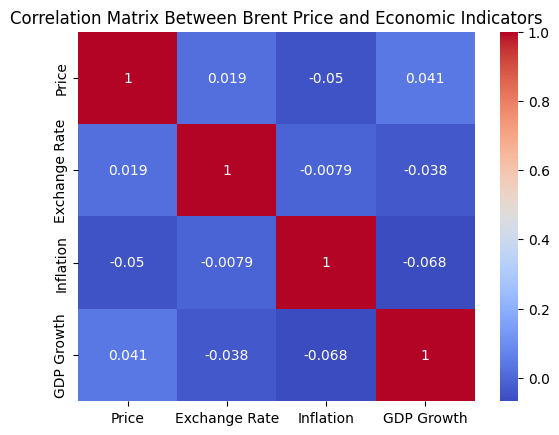

In [ ]:
brent_annual = merged_economic_data_2.groupby("Year")['Price'].mean().reset_index()
combined_data = pd.merge(brent_annual, filtered_economic_data, on="Year", how="inner")

correlation_matrix = combined_data[['Price', 'Exchange Rate', 'Inflation', 'GDP Growth']].corr()
print("Correlation Matrix:\n", correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix Between Brent Price and Economic Indicators")
plt.show()


In [123]:
combined_data.to_csv('../data/final.csv')

In [124]:
combined_data.head()

,Year,Price,Country Name,Country Code,Exchange Rate,Inflation,GDP Growth
0,1987,18.525813,Aruba,ABW,1.79,3.643045,16.078431
1,1987,18.525813,Africa Eastern and Southern,AFE,NaN,12.563443,3.964516
2,1987,18.525813,Afghanistan,AFG,39.276429,NaN,NaN
3,1987,18.525813,Africa Western and Central,AFW,NaN,0.248789,1.404582
4,1987,18.525813,Angola,AGO,0.0,NaN,4.082749
